In [1]:
import itertools

import numpy as np
import pandas as pd
from persistomics import spatial
import scipy.stats

import skimage
from skimage import morphology

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

plt.rcParams['figure.figsize'] = (10,5)
plt.rc('axes', linewidth=2)

sns.set()
sns.set_style("white")
sns.set_context("poster")

sns.set_palette('muted')

In [101]:
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def hex_to_rgb(h):
    return tuple(int(h[i+1:i+3], 16) for i in (0, 2, 4))

In [3]:
def readfile(fname):
    with open(fname, 'r') as f:
        return [line.rstrip() for line in f.readlines()]

In [4]:
ACTUAL_CELLTYPES = ['PT', 'TAL', 'DCT', 'ENDO', 'VSM', 'CCD', 'IMMUNE', 'PODS', 'UROTHELIUM']
PRED_CELLTYPES = ['CCD', 'DCT', 'ENDO', 'IMMUNE', 'PODS', 'PT', 'TAL', 'UROTHELIUM', 'VSM']

In [5]:
ACTUAL_COLOURS = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
PRED_COLOURS = [ACTUAL_COLOURS[ACTUAL_CELLTYPES.index(ct)] for ct in PRED_CELLTYPES]

bounds=list(range(len(ACTUAL_CELLTYPES)))

actual_cmap = colors.ListedColormap(ACTUAL_COLOURS)
actual_norm = colors.BoundaryNorm(bounds, actual_cmap.N)

pred_cmap = colors.ListedColormap(PRED_COLOURS)
pred_norm = colors.BoundaryNorm(bounds, pred_cmap.N)

ctypemap = dict(zip(ACTUAL_CELLTYPES, ACTUAL_COLOURS))

In [6]:
# A ground truth cell is detected if there is a predicted cell within some threshold of centre-to-centre distance
def detected(gtcell, predcells, threshold=10):
    x0, y0 = gtcell
    
    for x,y in predcells:
        dsquared = (x-x0)**2 + (y-y0)**2
        if dsquared < threshold*threshold:
            return True
    return False

# returns (no. cells detected, total no. cells) for teh given experiment and cell type
def getsparsescore(i, ct, threshold=20):
    
    cellcoords = np.loadtxt(f'../topact-data/syntheticdata/cellcoords/coords_{i}.txt')
    celltypes = readfile(f'../topact-data/syntheticdata/celltypes/celltypes_{i}.txt')
    
    gtxs = []
    gtys = []
    for (x,y), thect in zip(cellcoords, celltypes):
        if thect == ct:
            gtxs.append(x)
            gtys.append(y)
            
    if len(gtxs) == 0:
        return 0, 0
    
    predicted = np.loadtxt(f'../topact-data/syntheticdata/topactpreds/topactpreds_{i}.txt')
    
    # create a binary mask of the given cell type
    sparsearr = np.zeros_like(predicted)
    sparsearr[np.where(predicted == PRED_CELLTYPES.index(ct))] = 1
    
    # cell detection
    dilated = morphology.binary_dilation(sparsearr, footprint = np.ones((5,5)))
    labelled = morphology.label(dilated)
    rp = skimage.measure.regionprops(labelled)
    predcoords = [props.centroid for props in rp]
    
    scores = [detected(cell, predcoords, threshold=20) for cell in zip(gtxs,gtys)]

    found_cells = sum(scores)
    total_cells = len(scores)
    return found_cells, total_cells

In [7]:
sparse_celltypes = ['IMMUNE', 'PODS', 'UROTHELIUM']

In [8]:
foundcells = {ct: [] for ct in sparse_celltypes}
totalcells = {ct: [] for ct in sparse_celltypes}
for i in range(100):
    print(i)
    for ct in sparse_celltypes:
        
        a, b = getsparsescore(i, ct)
        foundcells[ct].append(a)
        totalcells[ct].append(b)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
rows = [{'Total': totalcells[ct][i],
        'Found': foundcells[ct][i],
        'Cell type': ct,
         'Sample': i
       } for i in range(100) for ct in sparse_celltypes]

In [11]:
df = pd.DataFrame(rows)

df['Recall'] = df['Found'] / df['Total']

df['Missed'] = df['Total'] - df['Found']

In [12]:
df

,Total,Found,Cell type,Sample,Recall,Missed
0,8,7,IMMUNE,0,0.875,1
1,5,5,PODS,0,1.000,0
2,3,3,UROTHELIUM,0,1.000,0
3,10,8,IMMUNE,1,0.800,2
4,5,4,PODS,1,0.800,1
...,...,...,...,...,...,...
295,4,4,PODS,98,1.000,0
296,1,1,UROTHELIUM,98,1.000,0
297,10,8,IMMUNE,99,0.800,2
298,2,2,PODS,99,1.000,0


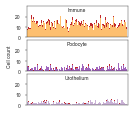

In [102]:
plt.rc('axes', linewidth=1*cm)

sns.set(style="ticks", context='paper', palette='muted', font="Arial")
cm = 1/2.54  # centimeters in inches

plt.rcParams['figure.figsize'] = (4.6*cm,4.6*cm)


fig, axs = plt.subplots(3)

# '#5A7DBF', '#D98A5F', '#75BF71'
#'#fdbf6f','#ff7f00','#cab2d6'

# '#fdbf6f','#A065BD','#cab2d6'

df[df['Cell type'] == 'IMMUNE'].plot.bar(x='Sample', y='Total', color='#c1272d', linewidth=0, width=1.05, ax=axs[0])
df[df['Cell type'] == 'IMMUNE'].plot.bar(x='Sample', y='Found', color='#fdbf6f', linewidth=0, width=1.05, ax=axs[0])
df[df['Cell type'] == 'PODS'].plot.bar(x='Sample', y='Total', color='#c1272d', linewidth=0, width=1.05, ax=axs[1])
df[df['Cell type'] == 'PODS'].plot.bar(x='Sample', y='Found', color='#A065BD', linewidth=0, width=1.05, ax=axs[1])

df[df['Cell type'] == 'UROTHELIUM'].plot.bar(x='Sample', y='Total', color='#c1272d', linewidth=0, width=1.05, ax=axs[2])
df[df['Cell type'] == 'UROTHELIUM'].plot.bar(x='Sample', y='Found', color='#cab2d6', linewidth=0, width=1.05, ax=axs[2])

for i, ax in enumerate(axs):
    ax.legend().remove()
    ax.set_ylim([0,30])
    ax.set_xticks([])
    ax.set_yticks([0,10,20], fontsize=5)
    ax.tick_params( labelsize=5)
    ax.spines['left'].set_linewidth(1*cm)
    ax.spines['bottom'].set_linewidth(1*cm)
    ax.spines['right'].set_linewidth(1*cm)
    ax.spines['top'].set_linewidth(1*cm)
    ax.xaxis.set_tick_params(width=1*cm, length=2)
    ax.yaxis.set_tick_params(width=1*cm, length=2)
    ax.set_title(['Immune', 'Podocyte', 'Urothelium'][i], y=0.65, size=5)
    ax.set_xlabel("")
#     ax.set_ylabel(['Immune', 'Podocyte', 'Urothelium'][i], rotation=0, ha='left', va='center', fontsize=25,labelpad=-450)
#     ax.set_ylabel('Cell count', rotation=0, ha='right', va='center', fontsize=25)

plt.xlabel("")

plt.text(-20, 38, "Cell count", rotation='vertical', size=5)



# plt.xlabel("Iteration", labelpad=-1, size=5)
plt.subplots_adjust(hspace=0.1)

plt.savefig('./sparsebars.pdf', bbox_inches='tight', transparent=True)

/var/folders/xs/cvb16m5n40s38vn1rn61jq_00000gn/T/ipykernel_90397/2315137430.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Immune', 'Podocyte', 'Urothelium'], fontsize=5)


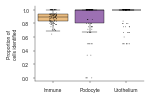

In [114]:
plt.rc('axes', linewidth=1*cm)
sns.set(style="ticks", context='paper', palette='muted', font="Arial")


plt.rcParams['figure.figsize'] = (5*cm,3.5*cm)


sns.boxplot(data=df, x='Cell type', y='Recall', 
            fliersize=0*cm, boxprops={'edgecolor': 'black'},
#             flierprops={'marker':'.', 'color': 'black', 'fillstyle':'full'},
            whiskerprops={'color': 'black'}, hue='Cell type',
            medianprops={'color': 'black'}, capprops={'color': 'black'},
            palette={'IMMUNE':'#fdbf6f' , 'PODS': '#A065BD', 'UROTHELIUM': '#cab2d6'}, linewidth=1*cm)

sns.stripplot(data=df, x='Cell type', y='Recall', hue='Cell type',
              s=2*cm, alpha=0.8, palette={ct: 'black' for ct in sparse_celltypes}, dodge=False)

# plt.legend().remove()

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticklabels(['Immune', 'Podocyte', 'Urothelium'], fontsize=5)
plt.xlabel("")
plt.ylabel("Proportion of\ncells identified", fontsize=5)

plt.tick_params( labelsize=5, width=1*cm, length=2)
ax.spines['left'].set_linewidth(1*cm)
ax.spines['bottom'].set_linewidth(1*cm)
plt.savefig('./proportionsparse.pdf', bbox_inches='tight', transparent='True')